# Frequentist Predictions on unseen data and nRMSE


   ............................................................................................................................................................................................................................................

## Import required libraries 

In [5]:
# Common python libraries
import numpy as np
# from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# import scipy
import pandas as pd
# import seaborn as sns
import pickle
from scipy.io import loadmat

# import math

# Gaussian Process Fitting Scripts
import gaussianprocess as gp
# from fitderiv import fitderiv
# import genutils as gu
# import datetime

# Bayesian Optimisation Scripts
from bayes_opt import BayesianOptimization
# from bayes_opt.observer import JSONLogger
# from bayes_opt.event import Events
# from bayes_opt.util import load_logs

# Avoid unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

# Functions with Models compyled with Cython
# import Model1_Cython as M1
# import Model2_Cython as M2
# import Model3_Cython as M3

# Function to simulate the 3 models for all parameter draws (needed in separate file for multiprocessesing in windows)
import SolveALLCyGen as SAC

# Bhattacharyya Distance Function 
import BhattacharyyaDistanceV1 as BD

## Get experimental data and metadata

In [2]:
C1I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_1_Events_Inputs.csv"))
C1D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_1_Observables.csv"))

C2I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_2_Events_Inputs.csv"))
C2D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_2_Observables.csv"))

C3I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_3_Events_Inputs.csv"))
C3D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/Calibration_3_Observables.csv"))

P3I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/PI_3_Events_Inputs.csv"))
P3D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/PI_3_Observables.csv"))

B2I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/BangBang_2_Events_Inputs.csv"))
B2D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/BangBang_2_Observables.csv"))

D4I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_4_Events_Inputs.csv"))
D4D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_4_Observables.csv"))

D5I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_5_Events_Inputs.csv"))
D5D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_5_Observables.csv"))

D6I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_6_Events_Inputs.csv"))
D6D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_6_Observables.csv"))

D10I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_10_Events_Inputs.csv"))
D10D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_10_Observables.csv"))

D12I = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_12_Events_Inputs.csv"))
D12D = (pd.read_csv("E:/UNI/D_Drive/RSTAN/DynStim_12_Observables.csv"))


In [3]:
Inputs = [C1I, C2I, C3I, P3I, B2I, D4I, D5I, D6I, D10I, D12I]
Outputs = [C1D, C2D, C3D, P3D, B2D, D4D, D5D, D6D, D10D, D12D]

## Simulations

In [6]:
pM1f = loadmat("ParametersCSV/BestPEM1.mat")
pM2f = loadmat("ParametersCSV/BestPEM2.mat")
pM3f = loadmat("ParametersCSV/BestPEM3.mat")

In [28]:
pM1 = np.array(pM1f['bm1']['pe_results'][0,0]['fit'][0,0]['thetabest'][0,0].reshape(1,16))
pM2 = np.array(pM2f['bm2']['pe_results'][0,0]['fit'][0,0]['thetabest'][0,0].reshape(1,14))
pM3 = np.array(pM3f['bm3']['pe_results'][0,0]['fit'][0,0]['thetabest'][0,0].reshape(1,14))

In [11]:
df_empty = pd.DataFrame({'Val1' : [], 'Val2':[], 'Val3':[], 'Val4':[], 'Val5':[], 'Val6':[], 'Val7':[], 
                         'Val8':[], 'Val9':[], 'Val10':[]})

In [29]:
for exp in range(0,10):
    # Extract experimental data
    ivss = [Inputs[exp]['IPTGpre'][0]+1e-7,Inputs[exp]['aTcpre'][0]+1e-7,Outputs[exp]['RFPmean'][0],Outputs[exp]['GFPmean'][0]]
    pre = [Inputs[exp]['IPTGpre'][0]+1e-7,Inputs[exp]['aTcpre'][0]+1e-7]
    sp = list(np.around(np.append(np.asarray(Inputs[exp]['Switchingtimes']), Inputs[exp]['FinalTime'][0])).astype(int))
    ts =  np.around(np.asarray(Outputs[exp]['timeGFP'])).astype(int)
    t = np.linspace(0,(ts[-1]),(ts[-1])+1)

    IPTG = np.asarray(Inputs[exp]['IPTG'])+1e-7
    aTc = np.asarray(Inputs[exp]['aTc'])+1e-7
    inps = np.zeros([len(IPTG)*2])
    for i, j in enumerate(range(0, len(IPTG)*2, 2)):
        inps[j] = IPTG[i]
        inps[j+1] = aTc[i]
        
    # Simulation of the system for the two models and extract of results
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,3):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inps, ivss, pre, 'M1', ts))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inps, ivss, pre, 'M2', ts))
            elif i==2:
                r3 = p.apply_async(SAC.solveALLCy2, args=(t, pM3, sp, inps, ivss, pre, 'M3', ts))

        p.close()
        p.join() 

    solM1 = r1.get()
    solM2 = r2.get()   
    solM3 = r3.get()    

    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

    RFP_M3 = solM3[:,0:len(pM3[:,1])]
    GFP_M3 = solM3[:,len(pM3[:,1]):(len(pM3[:,1])*2)]
    
    
    tmp1 = ([RFP_M1, GFP_M1, RFP_M2, GFP_M2, RFP_M3, GFP_M3])
    
    df_empty['Val'+str(exp+1)] = tmp1
    


In [35]:
# df_empty.to_pickle('BayesSimulations\ValidationSetBayes.pkl')
simulations = df_empty

In [6]:
# df_empty = pd.read_pickle('BayesSimulations\ValidationSetBayes.pkl')
# simulations = df_empty

## Plot of Experiments

In [32]:
tags = ['Calibration 1','Calibration 2','Calibration 3','PI 3','BangBang2','DynStim 4',
        'DynStim 5','DynStim 6','DynStim 10','DynStim 12']

In [33]:
import seaborn as sns
import matplotlib.ticker
import matplotlib.gridspec as gridspec

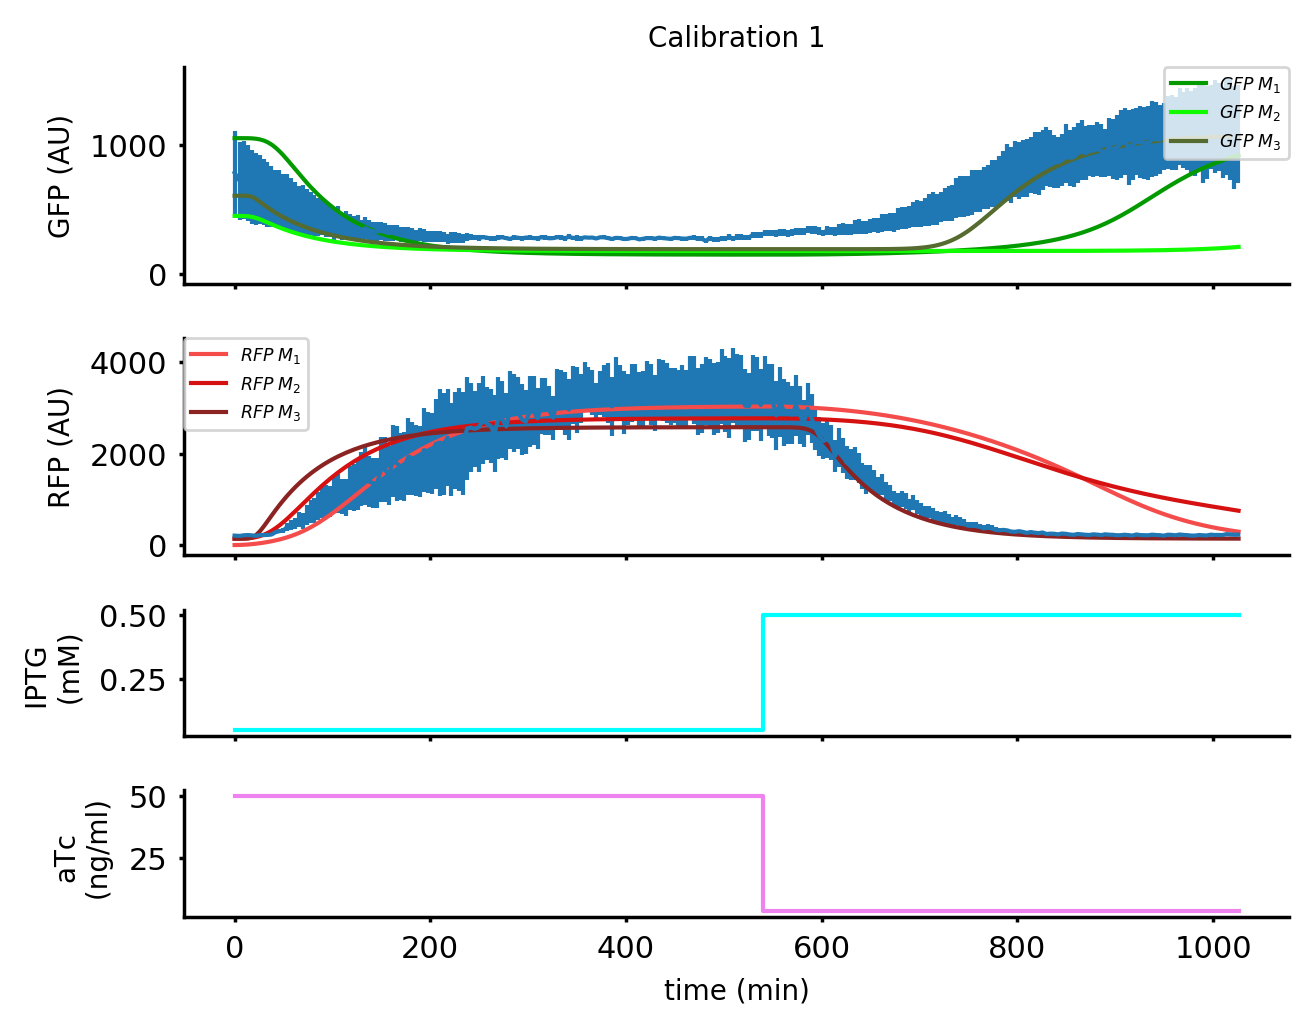

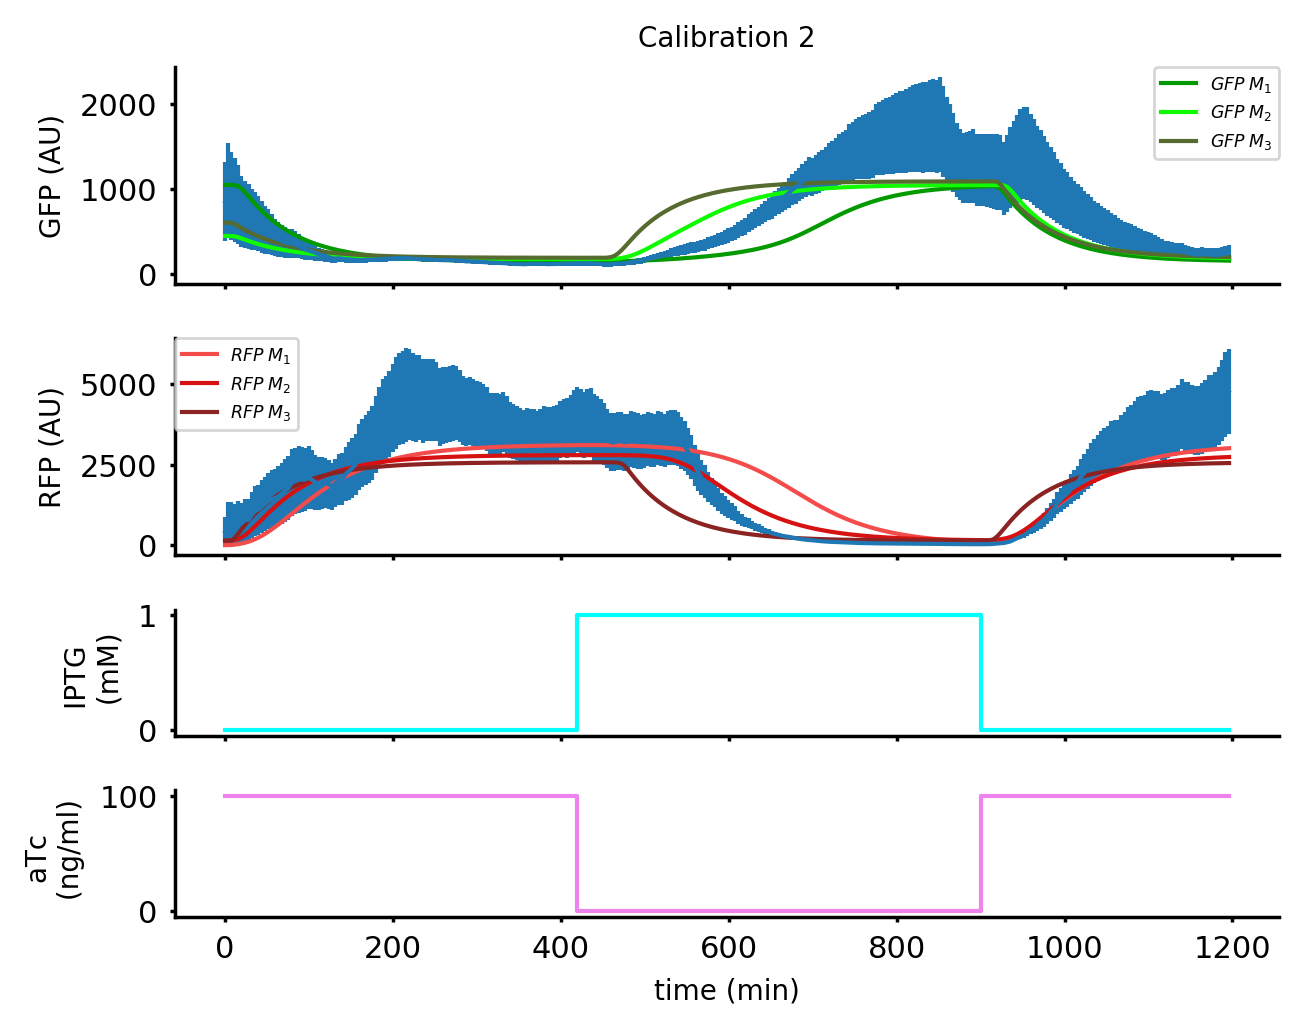

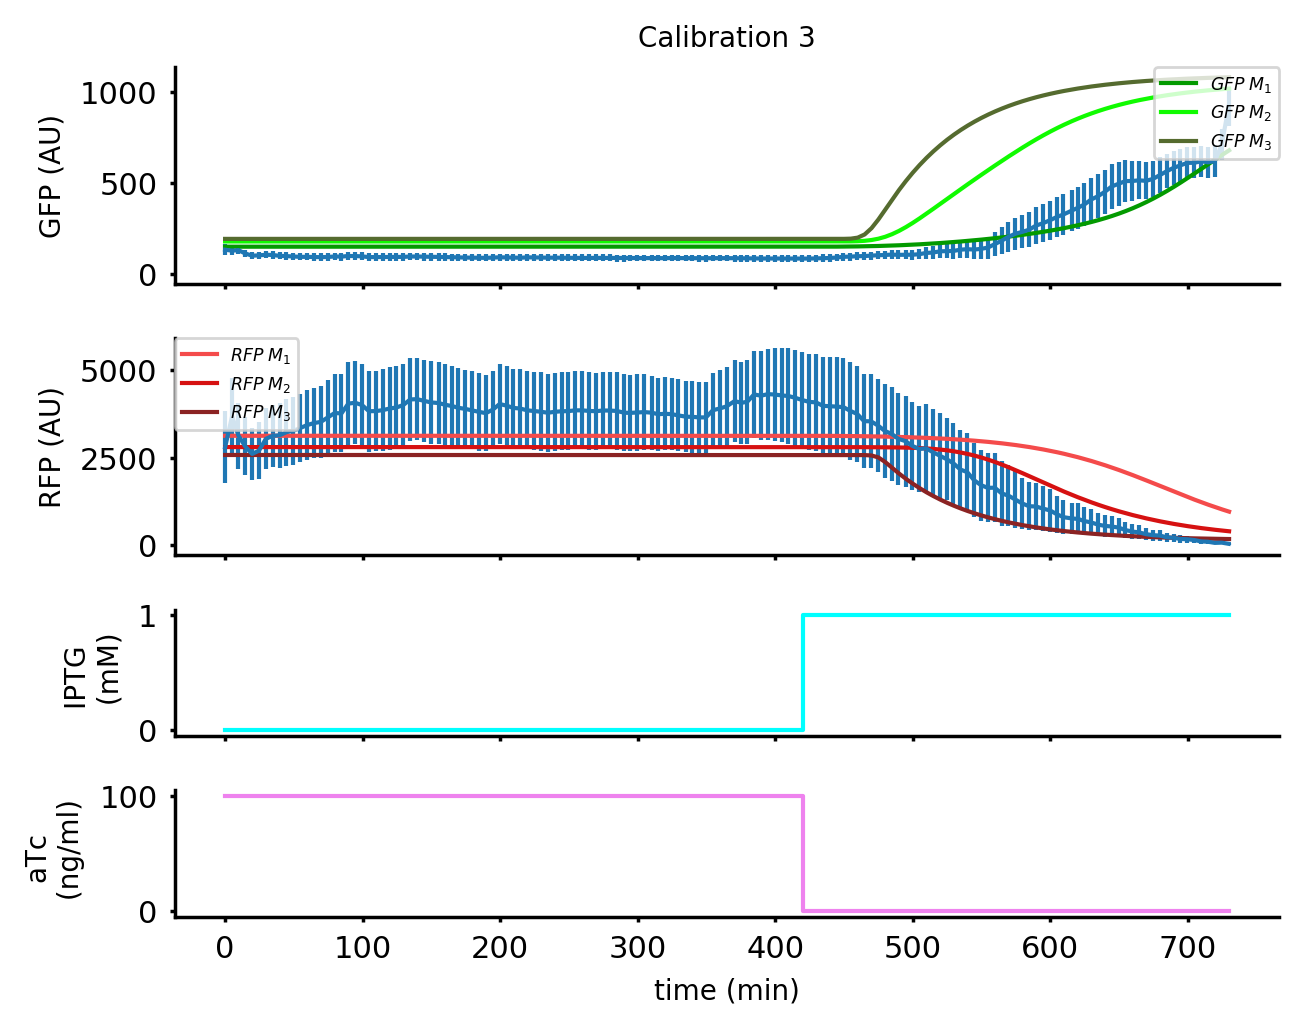

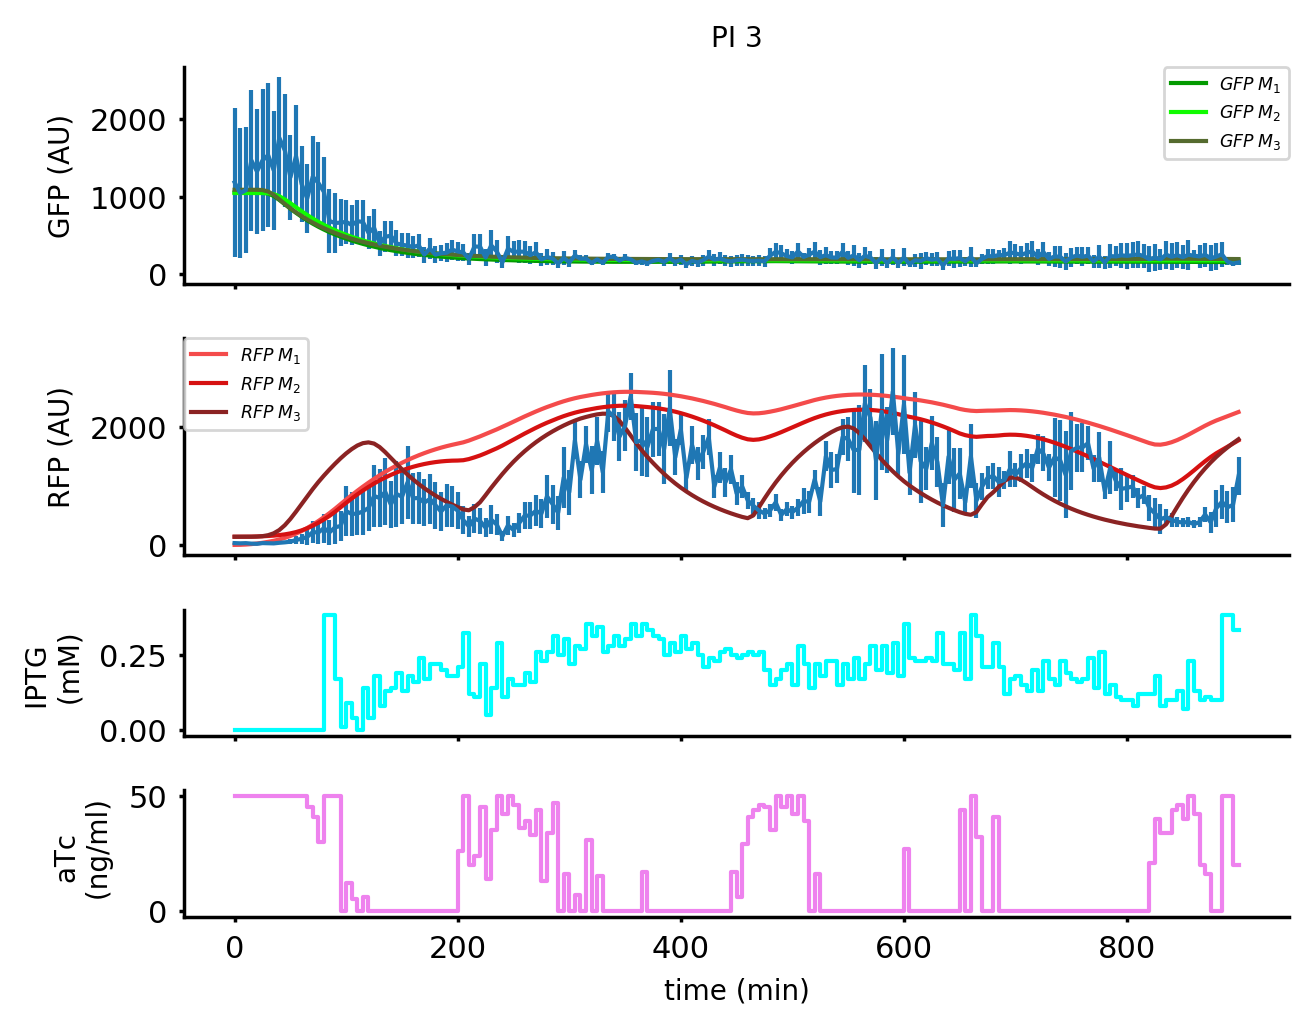

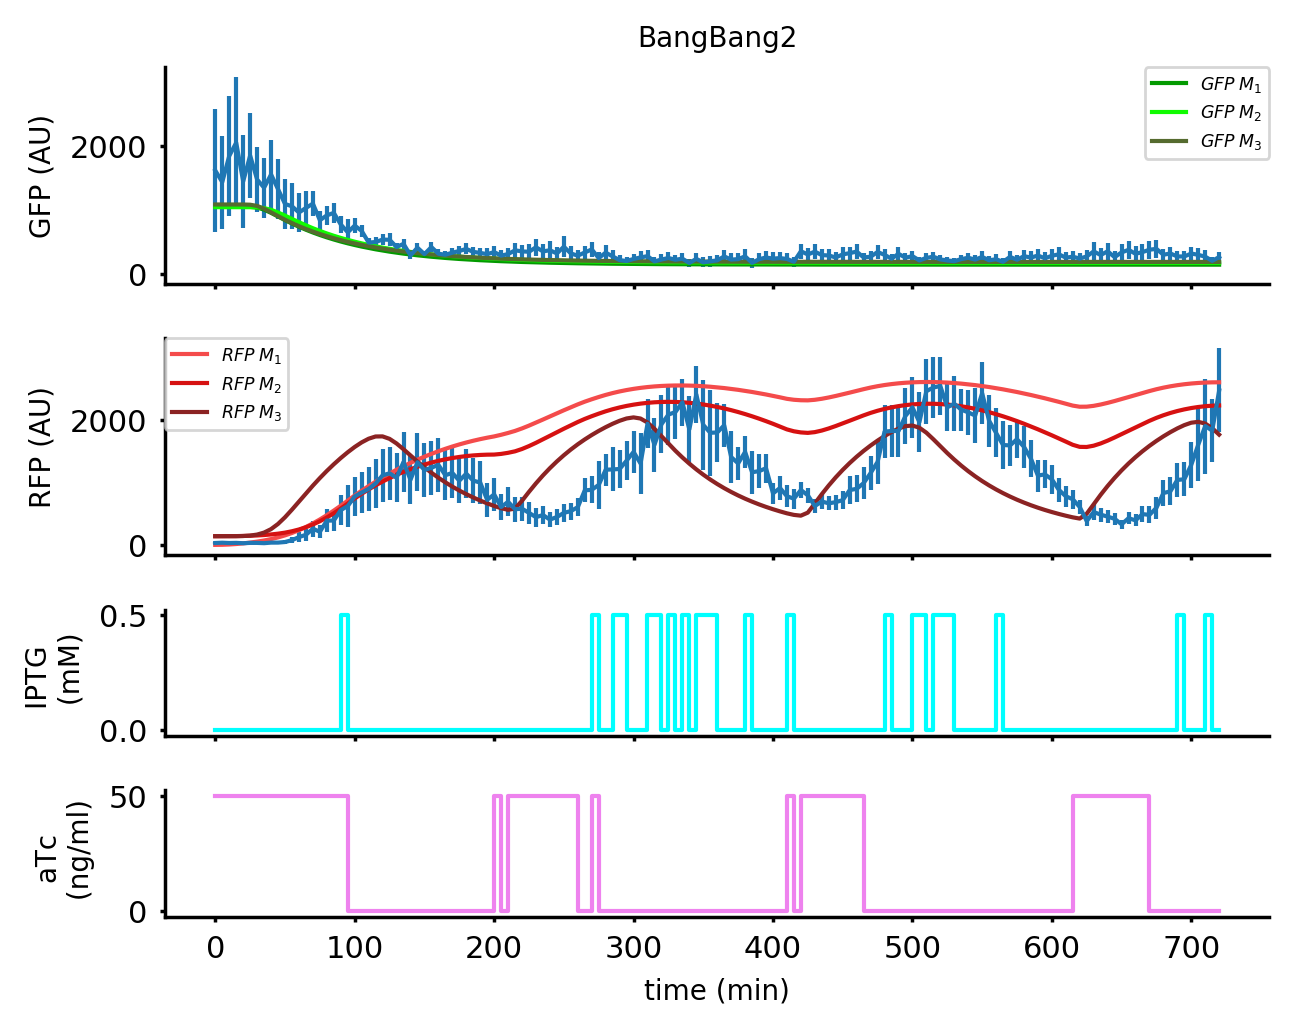

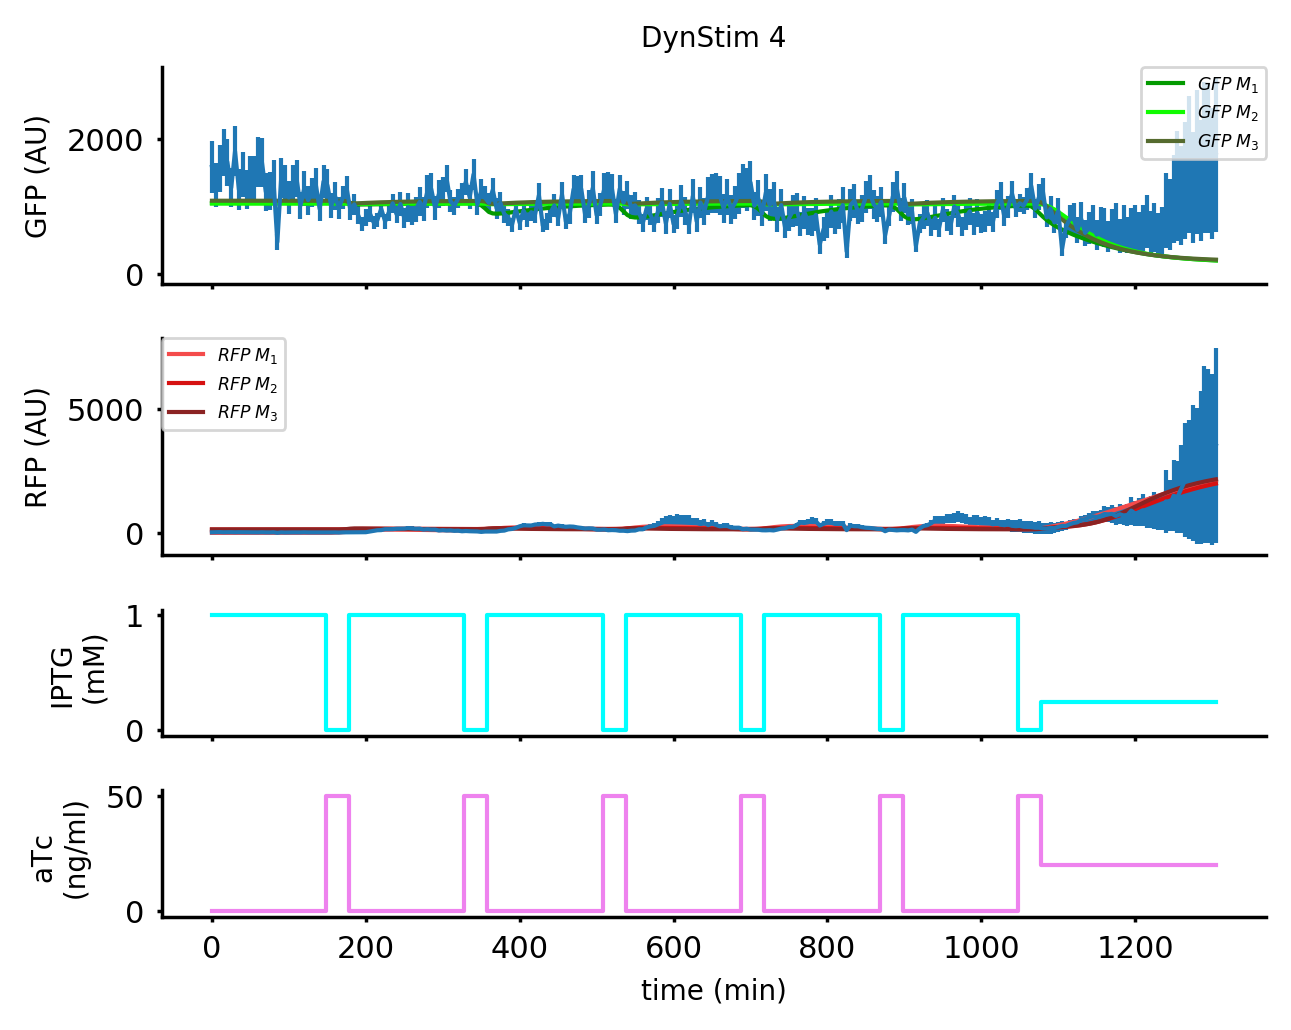

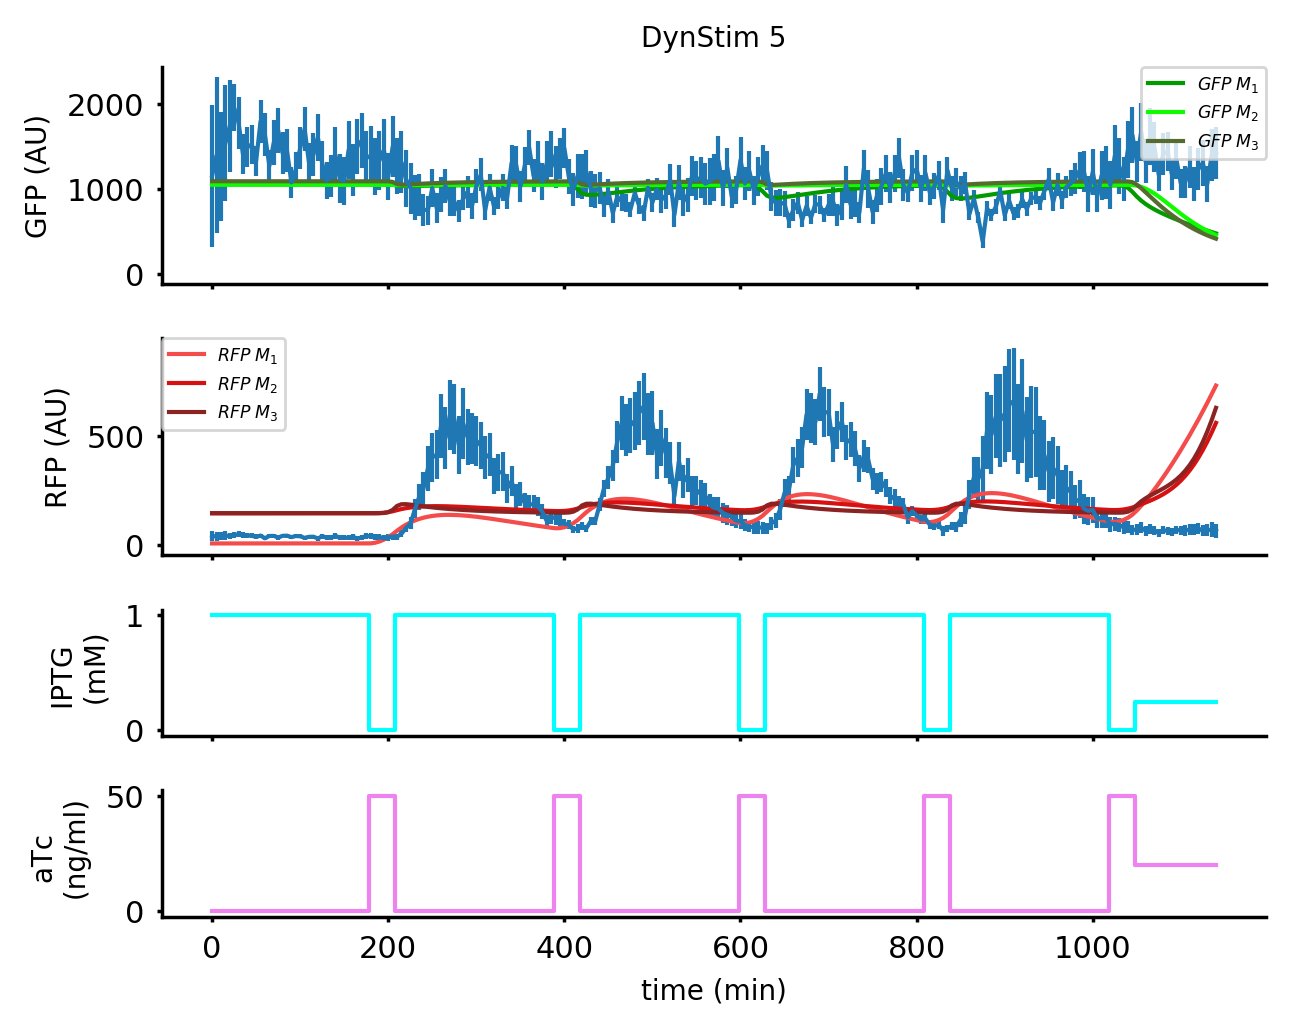

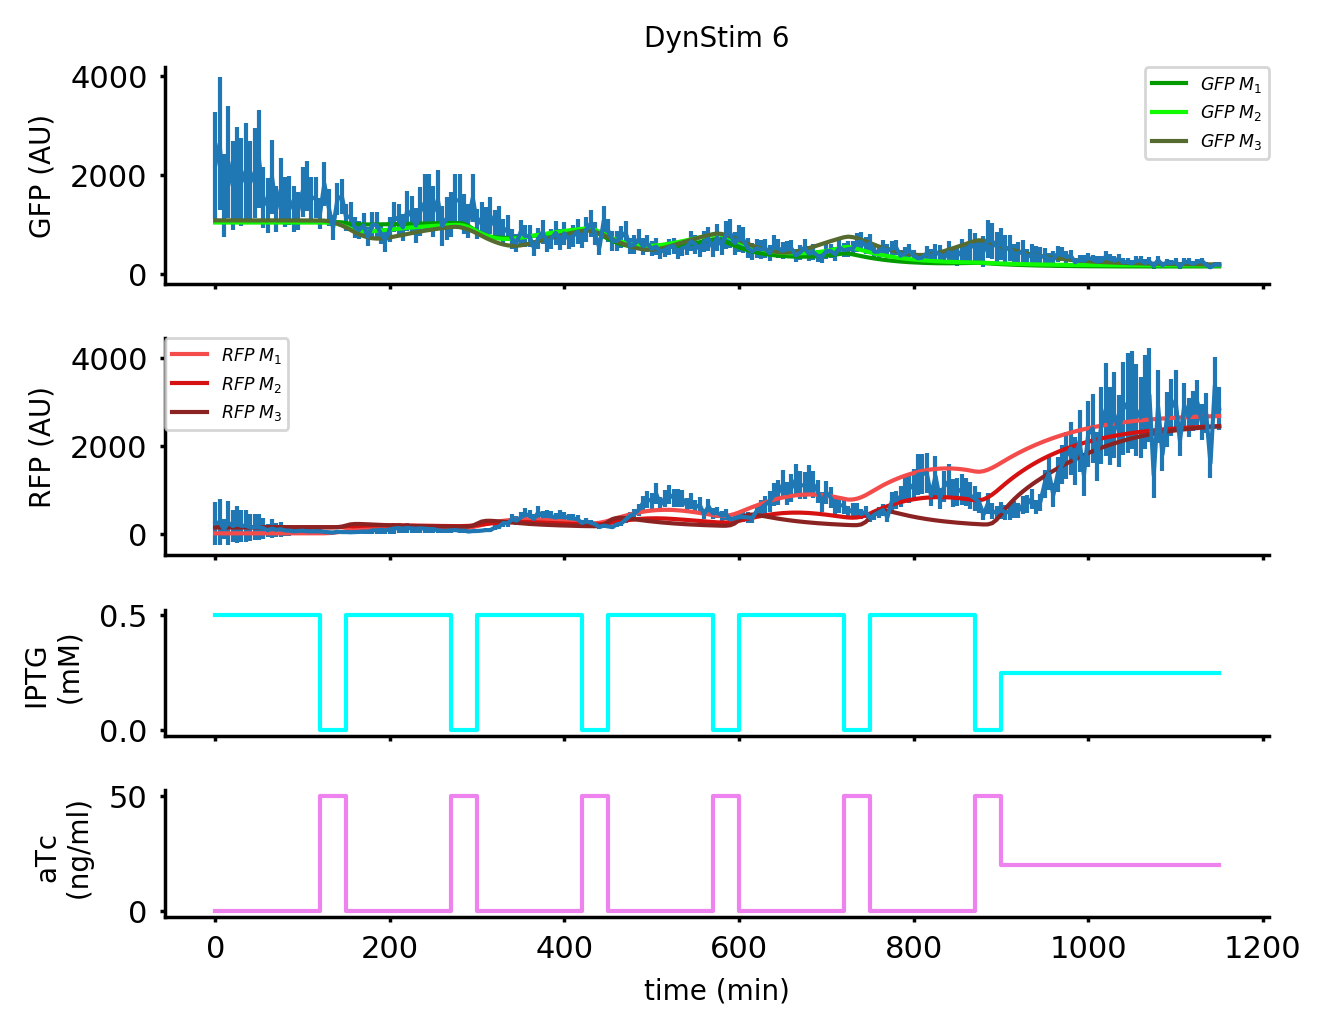

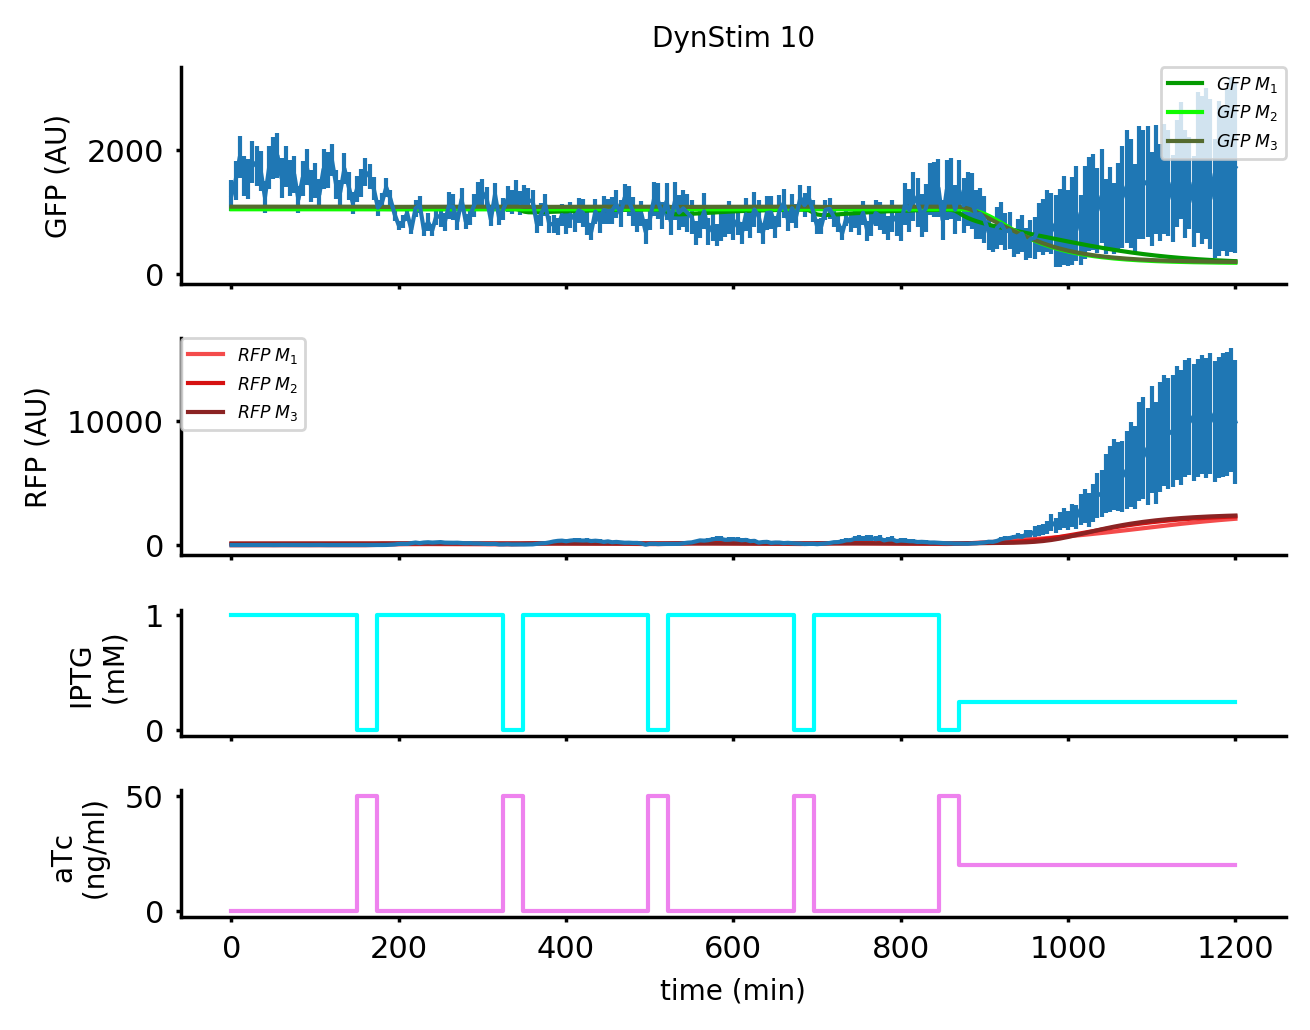

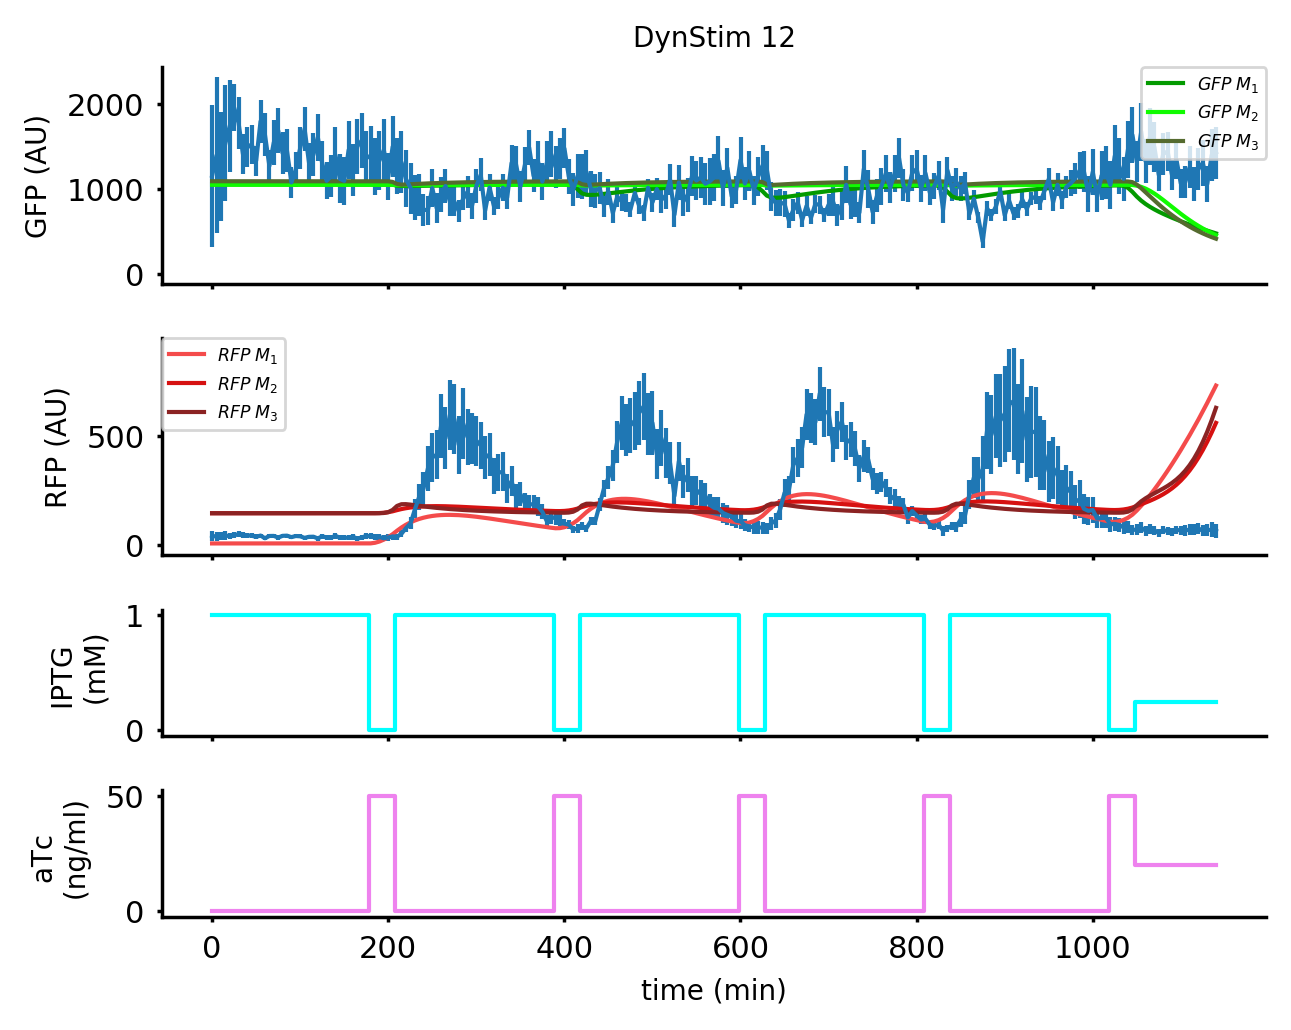

In [36]:
for exp in range(0,10):

    RFP_M1 = simulations['Val'+str(exp+1)][0]
    GFP_M1 = simulations['Val'+str(exp+1)][1]

    RFP_M2 = simulations['Val'+str(exp+1)][2]
    GFP_M2 = simulations['Val'+str(exp+1)][3]
    
    RFP_M3 = simulations['Val'+str(exp+1)][4]
    GFP_M3 = simulations['Val'+str(exp+1)][5]
    
    ts =  np.around(np.asarray(Outputs[exp]['timeGFP'])).astype(int)
    t = ts
    sp = list(np.around(np.append(np.asarray(Inputs[exp]['Switchingtimes']), Inputs[exp]['FinalTime'][0])).astype(int))
    
    fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
    gs = gridspec.GridSpec(10, 1, hspace = 1.5)
    
    ax1 = plt.subplot(gs[0:3, 0:2])
    ax1.errorbar(Outputs[exp]['timeGFP'], Outputs[exp]['GFPmean'], yerr= Outputs[exp]['GFPstd'])
    lines1 = ax1.plot(t, GFP_M1,color='#039a00')
    ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
    lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
    ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
    lines3 = ax1.plot(t, GFP_M3, color='darkolivegreen')
    ax1.plot(0,0,color='darkolivegreen', label = '$GFP \; M_{3}$')
    ax1.tick_params(length=1.5)
    ax1.set_ylabel('GFP (AU)')
    ax1.set_xlabel('time (min)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel('')
    ax1.set_title(tags[exp])
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(gs[3:6, 0:2])
    ax2.errorbar(Outputs[exp]['timeGFP'], Outputs[exp]['RFPmean'], yerr= Outputs[exp]['RFPstd'])
    lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
    ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
    lines2 = ax2.plot(t, RFP_M2, color='#d61111')
    ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
    lines3 = ax2.plot(t, RFP_M3, color='#8B2323')
    ax2.plot(0,0,color='#8B2323', label = '$RFP \; M_{3}$')
    ax2.tick_params(length=1.5)
    ax2.set_ylabel('RFP (AU)')
    ax2.set_xlabel('time (min)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    ax3 = plt.subplot(gs[6:8, 0:2])
    ax3.step(sp, [(Inputs[exp]['IPTG'][0])]+ list(Inputs[exp]['IPTG']), 'cyan')
    
    ax3.set_xticklabels('')
    ax3.set_ylabel('IPTG \n (mM)')
    ax3.tick_params(length=1.5)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    
    ax4 = plt.subplot(gs[8:10, 0:2])
    ax4.step(sp, [(Inputs[exp]['aTc'][0])]+ list(Inputs[exp]['aTc']), 'violet')
    
    ax4.set_xlabel('time (min)')
    ax4.set_ylabel('aTc \n (ng/ml)')
    ax4.tick_params(length=1.5)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    
    
    
    ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
    ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
    plt.show()

## nRMSE computation

In [45]:
def nRMSEbay(y_hat, y, sig):
    nRMSE = np.sqrt(np.sum(((y_hat-y)**2)/(sig**2))/len(y))
    return(nRMSE)

In [46]:
df_nRMSE = pd.DataFrame({'Val1' : [], 'Val2':[], 'Val3':[], 'Val4':[], 'Val5':[], 'Val6':[], 'Val7':[], 
                         'Val8':[], 'Val9':[], 'Val10':[]})

In [47]:
for exp in range(0,10):
    y_hat_r = np.array(Outputs[exp]['RFPmean'])
    sig_r = np.array(Outputs[exp]['RFPstd'])
    y_hat_g = np.array(Outputs[exp]['GFPmean'])
    sig_g = np.array(Outputs[exp]['GFPstd'])
    
    RFP_M1 = simulations['Val'+str(exp+1)][0]
    GFP_M1 = simulations['Val'+str(exp+1)][1]

    RFP_M2 = simulations['Val'+str(exp+1)][2]
    GFP_M2 = simulations['Val'+str(exp+1)][3]
    
    RFP_M3 = simulations['Val'+str(exp+1)][4]
    GFP_M3 = simulations['Val'+str(exp+1)][5]
    
    
    nrse = np.zeros([6,len(RFP_M1[1,:])])

    for i in range(0, len(RFP_M1[1,:])):
        y1 = RFP_M1[:,i]
        y2 = RFP_M2[:,i]
        y3 = RFP_M3[:,i]
        y4 = GFP_M1[:,i]
        y5 = GFP_M2[:,i]
        y6 = GFP_M3[:,i]

        nrse[0,i] = np.array(nRMSEbay(y_hat_r, y1, sig_r))
        nrse[1,i] = np.array(nRMSEbay(y_hat_r, y2, sig_r))
        nrse[2,i] = np.array(nRMSEbay(y_hat_r, y3, sig_r))
        nrse[3,i] = np.array(nRMSEbay(y_hat_g, y4, sig_g))
        nrse[4,i] = np.array(nRMSEbay(y_hat_g, y5, sig_g))
        nrse[5,i] = np.array(nRMSEbay(y_hat_g, y6, sig_g))
    
    nRMSE = [nrse[0,:], nrse[1,:],nrse[2,:],nrse[3,:],nrse[4,:],nrse[5,:]]
        
    df_nRMSE['Val'+str(exp+1)] = nRMSE
    

In [49]:
df_nRMSE.to_pickle('BayesSimulations\ValidationSetFrequentistRMSE.pkl')

In [ ]:
df_nRMSE = pd.read_pickle('BayesSimulations\ValidationSetFrequentistRMSE.pkl')